In [150]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
from numpy import linalg as LA

In [151]:
df = pd.read_csv('data100Hz_90deg.csv')
print(df)

      acc_x  acc_y  acc_z  gyr_x  gyr_y  gyr_z  mag_x  mag_y  mag_z
0       -44    221   -957   -910   -980   -840   -304   -169    736
1       -47    223   -956   -840   -980   -770   -312   -162    727
2       -46    223   -957  -1190   -980   -770   -312   -160    729
3       -46    223   -957  -1400  -1050   -840   -315   -160    733
4       -46    223   -957  -1400   -980   -840   -304   -162    729
...     ...    ...    ...    ...    ...    ...    ...    ...    ...
4994    -30    -30   -983   -210  -1050   -770   -169   -157    693
4995    -30    -31   -983   -140  -1050   -770   -168   -138    694
4996    -30    -31   -984   -140   -980   -770   -178   -145    699
4997    -30    -32   -984   -280  -1050   -770   -174   -148    708
4998    -30    -31   -983   -140   -980   -770   -169   -145    705

[4999 rows x 9 columns]


## Extended Kalman filter 

[2].A. M. Sabatini "Kalman-Filter-Based Orientation Determination Using Inertial/Magnetic Sensors: Observability Analysis and Performance Evaluation" 2011.



## Quaterion in orientation representation [2].

The 3D orientation of a rigid body is represented using two right-h anded coordinate systems:   
The earth-fixed frame: $E = \{e_1, e_2, e_3\}$,  
and  
The Body-fixed frame : $B = \{e_1', e_2', e_3'\}$
  
An arbitrary vector $x$ can be represented in either of these two frames:  
$x_B = Cx_E$,  
where:
$C$ - orientation matrix, colums - $e_i$ with respect to B, rows = $e_i'$ with respect to E.  
  
The Quaterions are derived by formulating the orientation matrix as a homogeneus quadratic function of the Euler symmetric parameters  
$q_i$, for $i =1,2,3,4$  
$C(\bar{q}) = I_{3x3} - 2q_4[q\times]+ 2[q\times]^2$
Where the operator:  
  
$$[q\times] = \begin{bmatrix} 0 & -q_3 & q_2 \\ q_3 & 0 & -q_1 \\ -q_2 & q_1 & 0 \end{bmatrix}$$
  
Is a Skew-symmetric matrix ($A^T = -A$)
And $I$ is an identity matrix.

Common notation on quaterions:

$q = [q_1 q_2 q_3] = sin(\theta/2)n^T, q_4 = cos(\theta/2)$  
and the final:  
$\bar{q} = [q^T q_4]$
  
Quatrtion conjugate operation: $(q^{uv})^c = q^{vu} $ is denoted as:
$$ q^c = [q_0 -q_{v}^{T}]^T $$

In [152]:
#quat_e(np.array([1,2,3]))

In [153]:
#quat_e(np.array([1,2,3]))

In [154]:
# SKEW MATRIX 
def skew_mat(q):
    # calculate Skew-symmetric matrix from 3x1 vector
    #Input:
    # x - vector 3x1
    #Output:
    # skew-symmetric matrix
    
    return np.array([[  0.0,   -q[2],   q[1] ],
                     [  q[2],   0.0,   -q[0] ],
                     [ -q[1],   q[0],   0.0  ]])



#QUATERION OPERATIONS
def q_conjugate(q):
    # quaterion conjugate operation, see quaterion description above.
    #Input:
    #    q - quaterion (vector 4x1), np.array!
    #Output:
    #    q_c - quaterion conjugate, np.array!
    q_c = np.hstack(([q[0]],-q[1:]))
    return q_c/LA.norm(q_c)#np.hstack(([q[0]],-q[1:]))

def L_operator(q):
    # L operator 
    #Input:
    #    q - quaterion, np.array
    #Output:
    #    q^L 
    sk = skew_mat(q[1:])
    q_L = np.zeros([4,4])
    q_L[1:4, 1:4] = q[0]*np.identity(3)+sk;
    q_L[:,0] = q
    q_L[0,1:] = -q[1:]
    return q_L

def R_operator(q):
    # R operator
    #Input:
    #    q - quaterion, np.array
    #Output:
    #    q^R 
    sk = skew_mat(q[1:])
    q_R = np.zeros([4,4])
    q_R[1:4, 1:4] = q[0]*np.identity(3)-sk;
    q_R[:,0] = np.transpose(q)
    q_R[0,1:] = -q[1:]
    return q_R

# Quaterion exponential operation
def quat_e(eta, in_deg: bool = False):
    # Convert rotation vector eta to quaterion using quaterion exponential mapping
    #Input:
    #    eta - rotation vector, np.array(3x1)
    #Output:
    #    q - quaterion calculated from rotation vector.
    
    
    eta_norm = LA.norm(eta)
    
    if (eta_norm == 0):
        return np.array([1,0,0,0])
    
    q0 = np.cos(eta_norm)
    qv = eta*np.sin(eta_norm)/eta_norm
    q = np.hstack([q0,qv])
    return q/LA.norm(q)



def quat_multi(p, q):
    # Function for quaterion multiplication
    # Remember that quaterion multiplication can be done unig L an R 
    # operators, see section above.
    #Input:
    #    p - left hand quaterion
    #    q - right hand quaterion 
    #Output:
    #    (p o q) - quaterion multiplication
    #return L_operator(p)@q
    #return np.hstack([p[0]*q[0] - np.dot(p[1:],q[1:]), 
     #                p[0]*q[1:]+q[0]*p[1:]+p[1:]@q[1:]])
    return np.array([
            p[0]*q[0] - p[1]*q[1] - p[2]*q[2] - p[3]*q[3],
            p[0]*q[1] + p[1]*q[0] + p[2]*q[3] - p[3]*q[2],
            p[0]*q[2] - p[1]*q[3] + p[2]*q[0] + p[3]*q[1],
            p[0]*q[3] + p[1]*q[2] - p[2]*q[1] + p[3]*q[0]])

In [155]:
def quat2rot(a):
    # Convert quaterion q into rotation matrix representation
    # input:
    #    q - quaterion
    # Output:
    #    R - rotation matrix obtaineg by transforming quaterion q
    #return np.array([
    #    [1.0-2.0*(q[2]**2+q[3]**2), 2.0*(q[1]*q[2]-q[0]*q[3]), 2.0*(q[1]*q[3]+q[0]*q[2])],
    #    [2.0*(q[1]*q[2]+q[0]*q[3]), 1.0-2.0*(q[1]**2+q[3]**2), 2.0*(q[2]*q[3]-q[0]*q[1])],
    #    [2.0*(q[1]*q[3]-q[0]*q[2]), 2.0*(q[0]*q[1]+q[2]*q[3]), 1.0-2.0*(q[1]**2+q[2]**2)]])
    q = a / LA.norm(a)
    return np.array([[2*q[0]**2+2*q[1]**2-1, 2*q[1]*q[2]-2*q[0]*q[3], 2*q[1]*q[3]+2*q[0]*q[2]],
                     [2*q[1]*q[2]+2*q[0]*q[3], 2*q[0]**2+2*q[2]**2-1, 2*q[2]*q[3]-2*q[0]*q[1]],
                     [2*q[1]*q[3]-2*q[0]*q[2], 2*q[2]*q[3]+2*q[0]*q[1], 2*q[0]**2+2*q[3]**2-1]])

In [156]:
def quat_to_ypr(q):
    # Convert quaterion to ypr representation
    #Input:
    # q - Quaterion
    #Output:
    # psi, theta, psi
    phi = np.arctan((2*q[1]*q[2]-2*q[0]*q[3])/(2*q[0]**2+2*q[1]**2-1))
    theta = np.arcsin(2.0*q[1]*q[3] + 2*q[0]*q[2])
    psi = np.arctan((2*q[2]*q[3]-2*q[0]*q[1])/(2*q[0]**2+2*q[3]**2-1))
    
    roll  = np.arctan2(2.0 * (q[3] * q[2] + q[0] * q[1]) , 1.0 - 2.0 * (q[1] * q[1] + q[2] * q[2]));
    pitch = np.arcsin(2.0 * (q[2] * q[0] - q[3] * q[1]));
    yaw   = np.arctan2(2.0 * (q[3] * q[0] + q[1] * q[2]) , - 1.0 + 2.0 * (q[0] * q[0] + q[1] * q[1]));
    
    return [roll, pitch, yaw]
    #return [phi, theta, psi]

In [157]:
def cayley(R):
    # Transforming rotation matrix notation into quaterion notation.
    #Input:
    # R - Rotation matrix (direction cosine matrix)
    #Output:
    # quaterion [e0, e1, e2, e3]
    #Based on:
    # http://www.iri.upc.edu/files/scidoc/2083-A-Survey-on-the-Computation-of-Quaternions-from-Rotation-Matrices.pdf
    #Why Cayley? 
    # As stated in "A Survey on the Computation of Quaternions from Rotation Matrices" by Soheil Sarabandi and Federico Thomas, page 20:
    # Although they are used in Robotics, the second trigonometric method, Chiaverini-Siciliano’s and Hughes’s method should be avoided.
    # Cayley’s method, besides being the simplest one, is superior in terms of accuracy and speed.

    e0 = 0.25 * np.sqrt((R.trace() + 1.0)**2 + (R[2, 1]-R[1, 2])**2 + (R[0, 2]-R[2, 0])**2 +
                                                (R[1, 0]-R[0, 1])**2)
    
    e1 = 0.25 * np.sign(R[2, 1]-R[1, 2]) * np.sqrt((R[2, 1]-R[1, 2])**2 + (R[0,0]-R[1,1]-R[2,2] + 1.0)**2 +
                                            (R[1, 0]+R[0, 1])**2 + (R[2, 0]+R[0, 2])**2)
    
    e2 = 0.25 * np.sign(R[0, 2]-R[2, 0]) * np.sqrt((R[0, 2]-R[2, 0])**2 + (R[1, 0]+R[0, 1])**2 +
                                            (R[1,1]-R[0,0]-R[2,2] + 1.0)**2 + (R[2, 1]+R[1, 2])**2)
    
    e3 = 0.25 * np.sign(R[1, 0]-R[0, 1]) * np.sqrt((R[1, 0]-R[0, 1])**2 + (R[2, 0]+R[0, 2])**2 +
                                            (R[2, 1]+R[1, 2])**2 + (R[2,2]-R[0,0]-R[1,1] + 1.0)**2)
    
    q = np.array([e0,e1,e2,e3])
    
    return q/LA.norm(q)


## Prior quaterion estimation
Source:  
[3] Manon Kok et al. "Using Inertial Sensors for Position and Orientation Estimation"  
[4] M.D. Shuster, S.D. OH "Three-Axis Attitude Determination from Vector Observation"
   
### Modeling the prior [3]
  
A commonly used method to determine the initial orientation is to use the first accelerometer and magnetometer samples. This method is based on the fact that given two (or more) linearly independent vectors in two coordinate frames, the rotation between the two coordinate frames can be determined. The implicit assumption is that the accelerometer only measures the gravity vector and the magnetometer only measures the local magnetic field. Hence, the four vectors are given by the measurements:  
-> $y_{a,t}$,    
-> $y_{m,t}$,  
-> local gravity vector $g^n$,   
-> local magnetic field $m^n$.   
These vectors are linearly independent except when the measurements are obtained on the magnetic north or south poles where the dip angle
is $\delta = 0$ and the magnetic field does not contain any heading information.  

Local gravity vector can differ in different local tangent plane coordinates.  
ENU = [0, 0, 1]  
NED = [0, 0, -1]  
Local magnetic field vector vary with location, and can be checked using World Magnetic Model.  

For Prior (q0) estimation a TRIAD algorithm is used. 

### TRIAD algorithm [4]:

As stated in [4], given two nonparallel reference unit vectors $\bar{V}_1$ and $\bar{V}_2$ as well as the corresponding observation unit vectors $\bar{W}_1$ and $\bar{W}_2$ we have to find an orthogonal matrix $A$ which satisfies:  
$A\bar{V}_1 = \bar{W}_1$ and $A\bar{V}_2 = \bar{W}_2$  
where: $A$ is the direction-cosine matrix  
  
First step is to construct two triads of manifestly orthonormal reference  and observation according to:  
$\bar{r}_1 = \bar{V}_1$  
  
$\bar{r}_2 = \frac{\bar{V}_1\times\bar{V}_2}{\lVert\bar{V}_1\times\bar{V}_2\rVert}$   
   
$\bar{r}_3 = \frac{\bar{V}_1\times(\bar{V}_1\times\bar{V}_2)}{\lVert\bar{V}_1\times\bar{V}_2\rVert}$  
  
And:  
  
$\bar{s}_1 = \bar{W}_1$  
  
$\bar{s}_2 = \frac{\bar{W}_1\times\bar{W}_2}{\lVert\bar{W}_1\times\bar{W}_2\rVert}$   
   
$\bar{s}_3 = \frac{\bar{W}_1\times(\bar{W}_1\times\bar{W}_2)}{\lVert\bar{W}_1\times\bar{W}_2\rVert}$  
  
Knowing that there exist orthogonal matrix A which satisfies:
$A\bar{r}_i = \bar{s}_i$  
Which is equvalent to: 
  
$A = M_{obs}M_{ref}^T$  
where:  
$M_{ref} = [\bar{r}_1|\bar{r}_2|\bar{r}_3]$ and 
$M_{obs} = [\bar{s}_1|\bar{s}_2|\bar{s}_3]$
  
### Initial covariance calculation [3]
  
Validity of estimated q0 depends highly on on the model assumption:  
-> Sensor is far from magnetic material  
-> Linear acceleration is zero.  
Having stated that we can model that in 68% of the cases the orientation error is less than 5° [3]:
$\Sigma_{\eta,i} = \sigma^2_{\eta,i}I_{3x3}$, $\sigma_{\eta,i} = \frac{5}{180} \pi$,  

and  
  
$\Sigma_{q,i} = \frac{1}{4}(q_0)^R \frac{∂\exp_q{(e_{\eta,i})}}{∂e_{\eta,i}}  
\Sigma_{\eta,i} (\frac{∂\exp_q{(e_{\eta,i})}}{∂e_{\eta,i}})^T(q_0^C)^R$  
  
where:
$ e_{\eta,i} \sim N (0,\Sigma_{\eta,i})$, and  
  
$\exp_q{}$ is a mapping operation $\exp_q: R^3 \rightarrow \{q \in R^4:||{q}||_2=1\}$, sice we are assuming $\eta$ is small we can use following approximation:  
  
$\exp_q{(\eta)} \approx \begin{pmatrix} 1 \\ \eta \end{pmatrix}$

In [158]:
def TRIAD(acc, mag, LGV, LMF):
    # Estimate initial quaternion q0 using TRIAD method.
    # Setting LGV and LMF as reference unit vectors, respectivly V_1 and V_2
    # Setting acc and mag as observation unit vectors, respectivly W_1 and W_2
    
    #Inputs:
    #    acc - np.array of tri-axial accelerometer initial sample, in m/s^2,
    #    gyr - np.array of tri-axial magnetometer initial sample, in uT,
    #    LGV - local gravity vector
    #    LMF - local magnetic field vector
    #Outputs: 
    #    initial quaternion q0
    #    initial covariance matrix P0
    
    # Normalizing input values
    V1 = LGV/(LA.norm(LGV))
    V2 = LMF/(LA.norm(LMF))
    W1 = acc/(LA.norm(acc))
    W2 = mag/(LA.norm(mag))
    
    crV1V2 = np.cross(V1,V2)
    crW1W2 = np.cross(W1,W2)
    
    # Calculate M_ref and M_obs
    M_ref = np.s_[V1,crV1V2/LA.norm(crV1V2),np.cross(V1,crV1V2)/LA.norm(crV1V2)]
    M_obs = np.transpose(np.s_[W1,(crW1W2)/LA.norm(crW1W2),np.cross(W1,crW1W2)/LA.norm(crW1W2)])
    
    # Calculate A
    A = M_obs@M_ref
    
    # Calculate initial covariance Cov_ni
    sigma_ni = 5*np.pi/180
    Cov_ni = sigma_ni**2* np.identity(3)
    
    # Calculater quaterion from given rotation matrix (using Cayley's method, Why? - look up Cayley's implementation above)
    
    return cayley(A)

In [159]:
def Initial_cov_q(q0, Cov_t):
    #Estimate initial covariance Cov_qi using functions presented in 3. 
    # Input:
    #    q0 - initial quaterion, np.array (4x1)
    #    Cov_t - type of requested initial covariance 1- Cov_ni, 2- Cov_qi
    # Output
    #    Cov_init - initial covariance(cov_ni np.array(3x3), Cov_qi)
    
    sigma_ni = 5*np.pi/180
    Cov_ni = sigma_ni**2* np.identity(3)
    
    if (Cov_t == 1):
        return Cov_ni
    
    q_R = R_operator(q0)
    q_cR = R_operator(q_conjugate(q0))
    exp_q = np.zeros([4,3]);
    exp_q[1,0] = 1
    exp_q[2,1] = 1
    exp_q[3,2] = 1
    
    return (1/4)*q_R@exp_q@Cov_ni@np.transpose(exp_q)@q_cR

In [160]:
def initial_cov_awm(sigma_a, sigma_w, sigma_m):
    #Calcuate covariance matrices for accelerometer, gyroscope and magnetometer
    # Input:
    #    sigma_a - accelerometr error, np.array([sigma(ax), sigma(ay), sigma(az)])
    #    sigma_w - gyroscope error, np.array([sigma(wx), sigma(wy), sigma(wz)])
    #    sigma_m - magnetometer error, np.array([sigma(mx), sigma(my), sigma(mz)])
    # Output:
    #    Cov_a, Cov_w, Cov_m - covariance matrices for respectively acceletometer, gyroscope annd magnetometer
    
    Cov_a = (sigma_a**2)*np.identity(3)
    Cov_w = (sigma_w**2)*np.identity(3)
    Cov_m = (sigma_m**2)*np.identity(3)
    Z = np.zeros((3,3)) 
    return Cov_a, Cov_w, Cov_m

## EKF Quaterions as states
  
    Sources:
    
[5] https://arxiv.org/pdf/1711.02508.pdf  
[6] https://www.iri.upc.edu/people/jsola/JoanSola/objectes/notes/kinematics.pdf  
[3] Manon Kok et al. "Using Inertial Sensors for Position and Orientation Estimation"   
  
#### Steps of EKF with Quaterions as states [3]:
  
1. Compute initial quaterion $q_{init}$ and initial covariance $\Sigma_{q,i}$ using methods descripted in 2. 
   
  
2. For t = 2,...,N loop:  

TIME UPDATE CALCULATIONS  
First, we need to update current quaterion with respect to previous quaterion:  
$q_{t|t-1} = q_{t-1|t-1} \odot \exp_q{(\frac{T}{2} y_{\omega,t-1})}$  
  
Now estimate F and G values, using:  
$F_{t-1} = (\exp_q{(\frac{T}{2} y_{\omega,t-1})})^R$ and 
$G_{t-1} = -\frac{T}{2}(q_{t-1|t-1})^L  \frac{∂\exp_q{(e_{\omega,t-1})}}{∂e_{\omega,t-1}} $  

Kaiqiang Feng et al. A New Quaternion-Based Kalman Filter for
Real-Time Attitude Estimation Using the Two-Step
Geometrically-Intuitive Correction Algorithm

In [161]:
def H_mat(q, gn, mn):
    qw, qx, qy, qz = q
    a_ref = gn
    m_ref = mn
    
    #m_ref /= LA.norm(m_ref)
    
    v = np.r_[a_ref, m_ref]
    
    H =  np.array([[2*qw*v[0]+qz*v[1]-qy*v[2], 2*qz*v[0] + qy*v[1]+qz*v[2], qx*v[1]-qw*v[2], qw*v[1]+qx*v[2]],
                  [ -qz*v[0]+2*qw*v[1]+qx*v[2], qy*v[0]+qw*v[2], qx*v[0]+2*qy*v[1]+qz*v[2], -qw*v[0]+qy*v[2]],
                  [ qy*v[0]-qx*v[1]+2*qw*v[2], qz*v[0]-qw*v[1], qw*v[0]+qz*v[1], qx*v[0]+qy*v[1]+2*qz*v[2] ]])
    
    H_2 =  np.array([[5*qw*v[3]+qz*v[4]-qy*v[5], 5*qz*v[3] + qy*v[4]+qz*v[5], qx*v[4]-qw*v[5], qw*v[4]+qx*v[5]],
                    [ -qz*v[3]+5*qw*v[4]+qx*v[5], qy*v[3]+qw*v[5], qx*v[3]+5*qy*v[4]+qz*v[5], -qw*v[3]+qy*v[5]],
                    [ qy*v[3]-qx*v[4]+5*qw*v[5], qz*v[3]-qw*v[4], qw*v[3]+qz*v[4], qx*v[3]+qy*v[4]+5*qz*v[5]]]) 
    
    H = np.vstack((H, H_2))
    
    return 2.0*H

In [162]:
def G_mat(q):
    # Calculate matrix G
    # Input:
    #
    #
    exp_q = np.zeros([4,3]);
    exp_q[1,0] = 1
    exp_q[2,1] = 1
    exp_q[3,2] = 1
    #exp_q
    
    qL = L_operator(q)
    return qL@exp_q



In [163]:
def H_mat2(Rbn,gn,mn):
    # Clculate matrix H
    g = gn/LA.norm(gn)
    m = mn#/LA.norm(mn)
    
    H1 = Rbn@skew_mat(g)
    H2 = Rbn@skew_mat(m)
    
    return np.vstack((H1, H2))


## Extended kalman filters 


In [164]:
def EKF_DS(q_prior,acc,gyr_prio,mag, T, P, Q, R):
    # Orientation estimation using orientation deviations as states [3]
    #Input:
    #    q_prior - quaterion from step t-1
    #    acc - array of tri-axial accelerometer sample, in m/s^2.
    #    gyr_prio - array of tri-axial gyroscope prior sample, in rad/s
    #    mag - array of tri-axial magnetometer sample, arbitrary units
    #    T - time between 2 samples
    #    P - previous sample covariance matrix 
    #    Q - gyro covariance matrix
    #    R - covariance matrix of noise variances (acc + mag)
    
    a = acc#/LA.norm(acc)
    m = mag/LA.norm(mag)
    gp = gyr_prio#/ LA.norm(gyr_prio)
    
    ############ TIME UPDATE #################
    qe = quat_e(T/2*gp)
    q_t = quat_multi(q_prior, qe)
    
    G = T/2*quat2rot(q_t)
    P_t = P+G@Q@np.transpose(G)

    ############ MEASURMENT UPDATE ##########
    gn = np.array([0.0, 0.0, -9.805])
    mn = np.array([2.0410, 19.7188, -45.5990])
   #m_ref = np.array([0.45399, 0, -0.8910])
    mn = mn/LA.norm(mn)
    #print(mn)
    R_bn = np.transpose(quat2rot(q_t))
    y=np.concatenate((a,m))
    y_2 = np.concatenate((-R_bn@gn, R_bn@mn))
    
    H = H_mat2(R_bn,gn,mn)
    et = y-y_2
    
    S = H@P_t@np.transpose(H) + R
    K = P_t@np.transpose(H)@ LA.inv(S)
    
    n_post = K@et
    P_pos = P_t - K@S@np.transpose(K)
    

    #print('Pt:',P_t)
    
    q_post = quat_multi(quat_e(n_post/2), q_t)
    #q_post = q_post/LA.norm(q_post)
    #print('Ppos:',P_pos)
    return P_pos, q_post

In [165]:
def EKF_QS(q_prior,acc,gyr_prio,mag, T, P, Q, R):
    # Orientation estimation using EKF with quaternion states [3]
    #Input:
    #    q_prior - quaterion from step t-1
    #    acc - array of tri-axial accelerometer sample, in m/s^2.
    #    gyr_prio - array of tri-axial gyroscope prior sample, in rad/s
    #    mag - array of tri-axial magnetometer sample, arbitrary units
    #    T - time between 2 samples
    #    P - previous sample covariance matrix 
    #    Q - gyro covariance matrix
    #    R - covariance matrix of noise variances (acc + mag)

    
    a = acc#/LA.norm(acc)
    m = mag/LA.norm(mag)
    gp = gyr_prio#/ LA.norm(gyr_prio)
    
    ############ TIME UPDATE #################
    qe = quat_e(T/2*gp)
    q_t = quat_multi(q_prior, qe)
    
    F = R_operator(qe)
    G = -T/2 * G_mat(q_prior)
    # Process Noise Covariance matrix 
    Q_t = G@Q@np.transpose(G)
    
    P_t = F@P@np.transpose(F) + Q_t
    
    ############ MEASURMENT UPDATE ##########
    gn = np.array([0.0, 0.0, -9.805])
    mn = np.array([2.0410, 19.7188, -45.5990])
    m_ref = np.array([0.45399, 0, -0.8910])
    
    mn = mn/LA.norm(mn)
    #print(mn)
    R_bn = np.transpose(quat2rot(q_t))
    y=np.r_[a,m]
    y_2 = np.r_[-R_bn@gn, R_bn@mn]
    et = y-y_2
    
    H = H_mat(q_t, gn, mn)
    S = H@P_t@np.transpose(H) + R
    K = P_t@np.transpose(H)@ LA.inv(S)
    
    q_post = q_t + K@et
    P_pos = P_t - K@S@np.transpose(K)
    

    #print('Pt:',H)
        
    J = 1/LA.norm(q_post)**3*np.matmul(q_post.reshape((-1, 1)),[q_post,])
    #print(J)
    P_pos = J@P_pos@np.transpose(J) 
    q_post = q_post/LA.norm(q_post)
    
    #print('Ppos:',P_pos)
    return P_pos, q_post

# Tests

In [168]:
acc = df.acc_x.values, df.acc_y.values ,df.acc_z.values
acc = np.transpose(acc)*9.805/1000
acc = acc[10:]
#acc[0] = np.array([0, 0, 9.805])

In [169]:
gyr = df.gyr_x.values, df.gyr_y.values ,df.gyr_z.values
gyr = (np.pi/180) * np.transpose(gyr)/1000
gyr = gyr[10:]
#gyr[0] = np.array([0,1,1])

In [170]:
mag = df.mag_x.values, df.mag_y.values ,df.mag_z.values
mag = np.transpose(mag)
mag = mag[10:]
#mag[0] = np.array([2.0410, 19.7188, -45.5990]);

In [171]:
# Uncertainty of measurments
sigma_m = 0.6
sigma_a = 0.2
sigma_w = 0.2

noises = np.array([sigma_a**2, sigma_w**2, sigma_m**2])
#noises = np.array([0.2**2, 0.2**2, 0.8**2])
#R = np.diag(np.repeat(noises[1:], 3))
# Covariance matrices
[Cov_a, Cov_w, Cov_m] = initial_cov_awm(sigma_a, sigma_w, sigma_m)
# Q matrix
Q = Cov_w
# R matrix
Z = np.zeros((3,3)) 
R = np.asarray(np.bmat([[Cov_a, Z], [Z, Cov_m]]))

In [172]:
a_ref = np.array([0.0, 0.0, -9.805])
m_ref = np.array([2.0410, 19.7188, -45.5990])
m_ref = np.array([0.45399, 0, -0.8910])   
q1 = np.zeros([len(acc),4]);
q2 = np.zeros([len(acc),4]);

init_q = TRIAD(acc[10],mag[10], a_ref, m_ref)
q1[0] = init_q 
q2[0] = init_q

P1 = Initial_cov_q(init_q,2)
P2 = Initial_cov_q(init_q,1)
print(P2)

[[0.00761544 0.         0.        ]
 [0.         0.00761544 0.        ]
 [0.         0.         0.00761544]]


In [173]:
for i in range(1,len(acc)):
    [P1, q1[i]] = EKF_QS(q1[i-1], acc[i], gyr[i-1], mag[i], 1/100, P1, Q, R)

[[ 1.32122104e-01 -3.67275361e-03 -3.06992543e-03 -3.38582153e-01]
 [-3.67275361e-03  1.02095854e-04  8.53383297e-05  9.41196655e-03]
 [-3.06992543e-03  8.53383297e-05  7.13313051e-05  7.86713145e-03]
 [-3.38582153e-01  9.41196655e-03  7.86713145e-03  8.67666128e-01]]
[[ 1.32026555e-01 -3.74656470e-03 -3.11240956e-03 -3.38456185e-01]
 [-3.74656470e-03  1.06317605e-04  8.83219577e-05  9.60449204e-03]
 [-3.11240956e-03  8.83219577e-05  7.33723095e-05  7.97880597e-03]
 [-3.38456185e-01  9.60449204e-03  7.97880597e-03  8.67648096e-01]]
[[ 1.31954636e-01 -3.78623374e-03 -3.15446602e-03 -3.38377435e-01]
 [-3.78623374e-03  1.08640109e-04  9.05125132e-05  9.70921604e-03]
 [-3.15446602e-03  9.05125132e-05  7.54096726e-05  8.08914455e-03]
 [-3.38377435e-01  9.70921604e-03  8.08914455e-03  8.67717063e-01]]
[[ 1.31899529e-01 -3.80085525e-03 -3.18266270e-03 -3.38316830e-01]
 [-3.80085525e-03  1.09526552e-04  9.17125357e-05  9.74903635e-03]
 [-3.18266270e-03  9.17125357e-05  7.67958912e-05  8.163398

 [-3.30541436e-01  1.24121712e-02  1.44863210e-02  8.74515264e-01]]
[[ 1.24853072e-01 -4.67133176e-03 -5.52055306e-03 -3.30447926e-01]
 [-4.67133176e-03  1.74776160e-04  2.06549462e-04  1.23635876e-02]
 [-5.52055306e-03  2.06549462e-04  2.44098969e-04  1.46112169e-02]
 [-3.30447926e-01  1.23635876e-02  1.46112169e-02  8.74594677e-01]]
[[ 1.24774529e-01 -4.65614264e-03 -5.55141714e-03 -3.30358450e-01]
 [-4.65614264e-03  1.73750721e-04  2.07159188e-04  1.23278051e-02]
 [-5.55141714e-03  2.07159188e-04  2.46991374e-04  1.46981727e-02]
 [-3.30358450e-01  1.23278051e-02  1.46981727e-02  8.74671353e-01]]
[[ 1.24712082e-01 -4.64876474e-03 -5.56918849e-03 -3.30287341e-01]
 [-4.64876474e-03  1.73287249e-04  2.07596944e-04  1.23117834e-02]
 [-5.56918849e-03  2.07596944e-04  2.48699725e-04  1.47494327e-02]
 [-3.30287341e-01  1.23117834e-02  1.47494327e-02  8.74732628e-01]]
[[ 1.24653500e-01 -4.64712402e-03 -5.58423540e-03 -3.30220547e-01]
 [-4.64712402e-03  1.73246332e-04  2.08182156e-04  1.23107

 [-3.21931611e-01  1.42630636e-02  1.63944675e-02  8.81810992e-01]]
[[ 1.17489205e-01 -5.20838125e-03 -5.98100024e-03 -3.21882252e-01]
 [-5.20838125e-03  2.30891299e-04  2.65142057e-04  1.42692725e-02]
 [-5.98100024e-03  2.65142057e-04  3.04473622e-04  1.63859975e-02]
 [-3.21882252e-01  1.42692725e-02  1.63859975e-02  8.81852798e-01]]
[[ 1.17443512e-01 -5.21144854e-03 -5.97740211e-03 -3.21827982e-01]
 [-5.21144854e-03  2.31253267e-04  2.65241757e-04  1.42808226e-02]
 [-5.97740211e-03  2.65241757e-04  3.04225711e-04  1.63797490e-02]
 [-3.21827982e-01  1.42808226e-02  1.63797490e-02  8.81898437e-01]]
[[ 1.17397775e-01 -5.21646971e-03 -5.97453432e-03 -3.21773598e-01]
 [-5.21646971e-03  2.31789369e-04  2.65473322e-04  1.42977346e-02]
 [-5.97453432e-03  2.65473322e-04  3.04052273e-04  1.63755012e-02]
 [-3.21773598e-01  1.42977346e-02  1.63755012e-02  8.81943873e-01]]
[[ 1.17352066e-01 -5.21888954e-03 -5.97246597e-03 -3.21719259e-01]
 [-5.21888954e-03  2.32094832e-04  2.65607937e-04  1.43075

[[ 1.09805896e-01 -5.21005068e-03 -5.77842964e-03 -3.12531027e-01]
 [-5.21005068e-03  2.47205561e-04  2.74173905e-04  1.48289167e-02]
 [-5.77842964e-03  2.74173905e-04  3.04084300e-04  1.64466446e-02]
 [-3.12531027e-01  1.48289167e-02  1.64466446e-02  8.89530036e-01]]
[[ 1.09761665e-01 -5.20884395e-03 -5.77709374e-03 -3.12475877e-01]
 [-5.20884395e-03  2.47190632e-04  2.74157465e-04  1.48288393e-02]
 [-5.77709374e-03  2.74157465e-04  3.04066198e-04  1.64465658e-02]
 [-3.12475877e-01  1.48288393e-02  1.64465658e-02  8.89574463e-01]]
[[ 1.09717319e-01 -5.20802511e-03 -5.77586583e-03 -3.12420531e-01]
 [-5.20802511e-03  2.47212800e-04  2.74166874e-04  1.48298736e-02]
 [-5.77586583e-03  2.74166874e-04  3.04059802e-04  1.64468025e-02]
 [-3.12420531e-01  1.48298736e-02  1.64468025e-02  8.89618789e-01]]
[[ 1.09673131e-01 -5.20609417e-03 -5.77641305e-03 -3.12365362e-01]
 [-5.20609417e-03  2.47129048e-04  2.74201620e-04  1.48277292e-02]
 [-5.77641305e-03  2.74201620e-04  3.04239947e-04  1.645208

 [-3.03278199e-01  1.51069308e-02  1.63763223e-02  8.96777111e-01]]
[[ 1.02525570e-01 -5.10815428e-03 -5.53536788e-03 -3.03227007e-01]
 [-5.10815428e-03  2.54504707e-04  2.75789866e-04  1.51077467e-02]
 [-5.53536788e-03  2.75789866e-04  2.98855179e-04  1.63712627e-02]
 [-3.03227007e-01  1.51077467e-02  1.63712627e-02  8.96816455e-01]]
[[ 1.02486269e-01 -5.10685670e-03 -5.53556270e-03 -3.03175526e-01]
 [-5.10685670e-03  2.54472970e-04  2.75835247e-04  1.51071356e-02]
 [-5.53556270e-03  2.75835247e-04  2.98990827e-04  1.63753364e-02]
 [-3.03175526e-01  1.51071356e-02  1.63753364e-02  8.96855749e-01]]
[[ 1.02447104e-01 -5.10418070e-03 -5.53367033e-03 -3.03124261e-01]
 [-5.10418070e-03  2.54303535e-04  2.75701824e-04  1.51024377e-02]
 [-5.53367033e-03  2.75701824e-04  2.98900664e-04  1.63732274e-02]
 [-3.03124261e-01  1.51024377e-02  1.63732274e-02  8.96895218e-01]]
[[ 1.02407870e-01 -5.10334332e-03 -5.53236168e-03 -3.03072841e-01]
 [-5.10334332e-03  2.54317497e-04  2.75696986e-04  1.51031

 [-2.94797295e-01  1.52469006e-02  1.63929258e-02  9.03118643e-01]]
[[ 9.61864138e-02 -4.97556585e-03 -5.35108480e-03 -2.94740135e-01]
 [-4.97556585e-03  2.57377883e-04  2.76802864e-04  1.52464251e-02]
 [-5.35108480e-03  2.76802864e-04  2.97693899e-04  1.63971126e-02]
 [-2.94740135e-01  1.52464251e-02  1.63971126e-02  9.03160267e-01]]
[[ 9.61448317e-02 -4.97414250e-03 -5.35161192e-03 -2.94683192e-01]
 [-4.97414250e-03  2.57341899e-04  2.76870631e-04  1.52457097e-02]
 [-5.35161192e-03  2.76870631e-04  2.97881328e-04  1.64026506e-02]
 [-2.94683192e-01  1.52457097e-02  1.64026506e-02  9.03201786e-01]]
[[ 9.61030037e-02 -4.97092634e-03 -5.35259976e-03 -2.94625901e-01]
 [-4.97092634e-03  2.57121085e-04  2.76863137e-04  1.52395200e-02]
 [-5.35259976e-03  2.76863137e-04  2.98121006e-04  1.64096279e-02]
 [-2.94625901e-01  1.52395200e-02  1.64096279e-02  9.03243585e-01]]
[[ 9.60613542e-02 -4.96901238e-03 -5.35442768e-03 -2.94568808e-01]
 [-4.96901238e-03  2.57034520e-04  2.76971084e-04  1.52373

 [-2.87155289e-01  1.54875425e-02  1.63282653e-02  9.08596001e-01]]
[[ 9.07162193e-02 -4.89175702e-03 -5.15955752e-03 -2.87102396e-01]
 [-4.89175702e-03  2.63781790e-04  2.78222592e-04  1.54816324e-02]
 [-5.15955752e-03  2.78222592e-04  2.93453960e-04  1.63291784e-02]
 [-2.87102396e-01  1.54816324e-02  1.63291784e-02  9.08633389e-01]]
[[ 9.06755805e-02 -4.89030555e-03 -5.15952297e-03 -2.87044484e-01]
 [-4.89030555e-03  2.63743427e-04  2.78262832e-04  1.54808519e-02]
 [-5.15952297e-03  2.78262832e-04  2.93581548e-04  1.63330921e-02]
 [-2.87044484e-01  1.54808519e-02  1.63330921e-02  9.08673926e-01]]
[[ 9.06350321e-02 -4.88713443e-03 -5.15895267e-03 -2.86986737e-01]
 [-4.88713443e-03  2.63519330e-04  2.78176050e-04  1.54746209e-02]
 [-5.15895267e-03  2.78176050e-04  2.93647964e-04  1.63353061e-02]
 [-2.86986737e-01  1.54746209e-02  1.63353061e-02  9.08714714e-01]]
[[ 9.05979744e-02 -4.88719085e-03 -5.15940073e-03 -2.86933865e-01]
 [-4.88719085e-03  2.63633205e-04  2.78317216e-04  1.54782

 [-2.78305819e-01  2.78921077e-02 -7.16635351e-03  9.14289722e-01]]
[[ 8.47010895e-02 -8.64285432e-03  2.56794616e-03 -2.78276958e-01]
 [-8.64285432e-03  8.81912279e-04 -2.62031867e-04  2.83952334e-02]
 [ 2.56794616e-03 -2.62031867e-04  7.78543408e-05 -8.43673027e-03]
 [-2.78276958e-01  2.83952334e-02 -8.43673027e-03  9.14251113e-01]]
[[ 8.46883295e-02 -8.78624546e-03  2.93272724e-03 -2.78249818e-01]
 [-8.78624546e-03  9.11555460e-04 -3.04264608e-04  2.88678642e-02]
 [ 2.93272724e-03 -3.04264608e-04  1.01559319e-04 -9.63569390e-03]
 [-2.78249818e-01  2.88678642e-02 -9.63569390e-03  9.14210513e-01]]
[[ 8.46845439e-02 -8.92721225e-03  3.31701495e-03 -2.78235379e-01]
 [-8.92721225e-03  9.41082220e-04 -3.49670614e-04  2.93308102e-02]
 [ 3.31701495e-03 -3.49670614e-04  1.29924395e-04 -1.08982214e-02]
 [-2.78235379e-01  2.93308102e-02 -1.08982214e-02  9.14156500e-01]]
[[ 8.47186354e-02 -9.10164011e-03  3.76007475e-03 -2.78274958e-01]
 [-9.10164011e-03  9.77823264e-04 -4.03958905e-04  2.98961

 [-0.27257201  0.06606516 -0.11085577  0.89871431]]
[[ 0.08263304 -0.02013042  0.03395773 -0.27246892]
 [-0.02013042  0.00490402 -0.00827252  0.06637678]
 [ 0.03395773 -0.00827252  0.0139548  -0.11197006]
 [-0.27246892  0.06637678 -0.11197006  0.89842166]]
[[ 0.08259372 -0.0202239   0.03429443 -0.27235957]
 [-0.0202239   0.00495202 -0.00839733  0.06668995]
 [ 0.03429443 -0.00839733  0.01423967 -0.11308868]
 [-0.27235957  0.06668995 -0.11308868  0.89812801]]
[[ 0.08255318 -0.02032859  0.03467725 -0.27224115]
 [-0.02032859  0.00500589 -0.00853922  0.06703897]
 [ 0.03467725 -0.00853922  0.01456651 -0.11435749]
 [-0.27224115  0.06703897 -0.11435749  0.89778785]]
[[ 0.08250345 -0.02045854  0.0351449  -0.27209516]
 [-0.02045854  0.00507315 -0.00871495  0.06747197]
 [ 0.0351449  -0.00871495  0.01497105 -0.11590735]
 [-0.27209516  0.06747197 -0.11590735  0.89736585]]
[[ 0.08243613 -0.02062697  0.03573947 -0.27190165]
 [-0.02062697  0.00516123 -0.00894264  0.06803456]
 [ 0.03573947 -0.00894264 

 [-0.23925189  0.10532692 -0.27179214  0.82821647]]
[[ 0.06889356 -0.03040876  0.07873069 -0.23878508]
 [-0.03040876  0.01342205 -0.03475075  0.10539676]
 [ 0.07873069 -0.03475075  0.08997243 -0.27288056]
 [-0.23878508  0.10539676 -0.27288056  0.82762906]]
[[ 0.06868357 -0.03040826  0.07911609 -0.23827817]
 [-0.03040826  0.01346264 -0.03502704  0.10549282]
 [ 0.07911609 -0.03502704  0.09113324 -0.27447085]
 [-0.23827817  0.10549282 -0.27447085  0.82663855]]
[[ 0.06859805 -0.03041405  0.07988842 -0.23786462]
 [-0.03041405  0.01348456 -0.03541982  0.1054611 ]
 [ 0.07988842 -0.03541982  0.09303705 -0.27701412]
 [-0.23786462  0.1054611  -0.27701412  0.82479854]]
[[ 0.06859114 -0.03036091  0.08074112 -0.23757084]
 [-0.03036091  0.01343883 -0.03573893  0.10515742]
 [ 0.08074112 -0.03573893  0.0950433  -0.27965325]
 [-0.23757084  0.10515742 -0.27965325  0.8228454 ]]
[[ 0.06863766 -0.03028     0.08164488 -0.23735671]
 [-0.03028     0.01335824 -0.03601823  0.10471163]
 [ 0.08164488 -0.03601823 

[[ 0.04441193 -0.03760833  0.12536842 -0.15907551]
 [-0.03760833  0.031847   -0.10616285  0.13470625]
 [ 0.12536842 -0.10616285  0.35389685 -0.44904706]
 [-0.15907551  0.13470625 -0.44904706  0.56977975]]
[[ 0.04427707 -0.03762763  0.12556064 -0.15853218]
 [-0.03762763  0.03197678 -0.10670419  0.13472412]
 [ 0.12556064 -0.10670419  0.35606406 -0.44956454]
 [-0.15853218  0.13472412 -0.44956454  0.56761773]]
[[ 0.04414175 -0.03764822  0.12577101 -0.15797053]
 [-0.03764822  0.03210993 -0.1072693   0.13473206]
 [ 0.12577101 -0.1072693   0.35835341 -0.45009798]
 [-0.15797053  0.13473206 -0.45009798  0.56533072]]
[[ 0.04400797 -0.03767388  0.1259923  -0.157401  ]
 [-0.03767388  0.03225146 -0.10785815  0.13474618]
 [ 0.1259923  -0.10785815  0.36070871 -0.45063003]
 [-0.157401    0.13474618 -0.45063003  0.56296789]]
[[ 0.04388029 -0.03770345  0.12621436 -0.15684511]
 [-0.03770345  0.03239611 -0.10844772  0.13476672]
 [ 0.12621436 -0.10844772  0.36303464 -0.45113892]
 [-0.15684511  0.13476672 -

 [-0.13110577  0.13938988 -0.45935662  0.45152662]]
[[ 0.03808743 -0.04049472  0.13340067 -0.13114585]
 [-0.04049472  0.04305417 -0.14183216  0.13943483]
 [ 0.13340067 -0.14183216  0.46723383 -0.45933637]
 [-0.13114585  0.13943483 -0.45933637  0.45157239]]
[[ 0.03812096 -0.04052157  0.13343631 -0.13121936]
 [-0.04052157  0.04307335 -0.14183924  0.13948268]
 [ 0.13343631 -0.14183924  0.46707237 -0.4593123 ]
 [-0.13121936  0.13948268 -0.4593123   0.45168115]]
[[ 0.03816567 -0.04055383  0.13348066 -0.13132159]
 [-0.04055383  0.04309142 -0.14183301  0.13953883]
 [ 0.13348066 -0.14183301  0.46683543 -0.45928429]
 [-0.13132159  0.13953883 -0.45928429  0.45185528]]
[[ 0.03822032 -0.04058975  0.13353459 -0.13144777]
 [-0.04058975  0.04310607 -0.14181294  0.13959675]
 [ 0.13353459 -0.14181294  0.46654467 -0.45925372]
 [-0.13144777  0.13959675 -0.45925372  0.4520767 ]]
[[ 0.0382772  -0.04062579  0.13358874 -0.13158132]
 [-0.04062579  0.04311849 -0.14178541  0.13965482]
 [ 0.13358874 -0.14178541 

[[ 0.04200358 -0.04443529  0.13900121 -0.1376274 ]
 [-0.04443529  0.04700779 -0.1470484   0.14559506]
 [ 0.13900121 -0.1470484   0.45999258 -0.45544628]
 [-0.1376274   0.14559506 -0.45544628  0.4509449 ]]
[[ 0.0420765  -0.04446848  0.1390377  -0.1378223 ]
 [-0.04446848  0.04699643 -0.14694175  0.14565725]
 [ 0.1390377  -0.14694175  0.45943655 -0.45542036]
 [-0.1378223   0.14565725 -0.45542036  0.45143927]]
[[ 0.0421471  -0.04449483  0.13906425 -0.13802138]
 [-0.04449483  0.04697335 -0.14681061  0.14570964]
 [ 0.13906425 -0.14681061  0.45884219 -0.45540123]
 [-0.13802138  0.14570964 -0.45540123  0.45198606]]
[[ 0.04221176 -0.04452087  0.1390872  -0.13820423]
 [-0.04452087  0.04695628 -0.14669566  0.14576439]
 [ 0.1390872  -0.14669566  0.45829048 -0.45538108]
 [-0.13820423  0.14576439 -0.45538108  0.45249016]]
[[ 0.04227031 -0.04454478  0.13910995 -0.13836741]
 [-0.04454478  0.04694164 -0.14659515  0.14581266]
 [ 0.13910995 -0.14659515  0.4578055  -0.45536181]
 [-0.13836741  0.14581266 -

 [-2.54784808e-01  2.61355836e-02 -2.96716932e-02  9.28204153e-01]]
[[ 6.99274282e-02 -7.17224749e-03  8.00583526e-03 -2.54774069e-01]
 [-7.17224749e-03  7.35636007e-04 -8.21134615e-04  2.61314154e-02]
 [ 8.00583526e-03 -8.21134615e-04  9.16570218e-04 -2.91685147e-02]
 [-2.54774069e-01  2.61314154e-02 -2.91685147e-02  9.28245578e-01]]
[[ 6.98997184e-02 -7.15953297e-03  7.84975907e-03 -2.54732499e-01]
 [-7.15953297e-03  7.33320727e-04 -8.04017672e-04  2.60911741e-02]
 [ 7.84975907e-03 -8.04017672e-04  8.81530267e-04 -2.86065350e-02]
 [-2.54732499e-01  2.60911741e-02 -2.86065350e-02  9.28310551e-01]]
[[ 6.98577139e-02 -7.14964725e-03  7.67351385e-03 -2.54667252e-01]
 [-7.14964725e-03  7.31736739e-04 -7.85352313e-04  2.60641369e-02]
 [ 7.67351385e-03 -7.85352313e-04  8.42896390e-04 -2.79738998e-02]
 [-2.54667252e-01  2.60641369e-02 -2.79738998e-02  9.28392954e-01]]
[[ 6.98012582e-02 -7.14361101e-03  7.47686392e-03 -2.54577913e-01]
 [-7.14361101e-03  7.31092527e-04 -7.65198347e-04  2.60540

 [-2.49533390e-01  2.34313568e-02  5.11464660e-03  9.32448130e-01]]
[[ 6.67463299e-02 -6.26107617e-03 -1.39313060e-03 -2.49478714e-01]
 [-6.26107617e-03  5.87314312e-04  1.30681294e-04  2.34021142e-02]
 [-1.39313060e-03  1.30681294e-04  2.90774469e-05  5.20712422e-03]
 [-2.49478714e-01  2.34021142e-02  5.20712422e-03  9.32480168e-01]]
[[ 6.67115782e-02 -6.25026372e-03 -1.41655024e-03 -2.49418538e-01]
 [-6.25026372e-03  5.85592452e-04  1.32717781e-04  2.33682321e-02]
 [-1.41655024e-03  1.32717781e-04  3.00789555e-05  5.29614050e-03]
 [-2.49418538e-01  2.33682321e-02  5.29614050e-03  9.32515897e-01]]
[[ 6.66794080e-02 -6.24434137e-03 -1.42817514e-03 -2.49362739e-01]
 [-6.24434137e-03  5.84765226e-04  1.33744636e-04  2.33521280e-02]
 [-1.42817514e-03  1.33744636e-04  3.05894173e-05  5.34098422e-03]
 [-2.49362739e-01  2.33521280e-02  5.34098422e-03  9.32548407e-01]]
[[ 6.66505331e-02 -6.23329257e-03 -1.44279737e-03 -2.49312781e-01]
 [-6.23329257e-03  5.82950120e-04  1.34933327e-04  2.33162

[[ 5.95394835e-02 -4.95481222e-03 -4.13739516e-03 -2.36525499e-01]
 [-4.95481222e-03  4.12334181e-04  3.44309606e-04  1.96833994e-02]
 [-4.13739516e-03  3.44309606e-04  2.87507343e-04  1.64361428e-02]
 [-2.36525499e-01  1.96833994e-02  1.64361428e-02  9.39617013e-01]]
[[ 5.94973023e-02 -4.95337146e-03 -4.15737946e-03 -2.36446599e-01]
 [-4.95337146e-03  4.12386577e-04  3.46117285e-04  1.96850578e-02]
 [-4.15737946e-03  3.46117285e-04  2.90497271e-04  1.65217278e-02]
 [-2.36446599e-01  1.96850578e-02  1.65217278e-02  9.39655952e-01]]
[[ 5.94657676e-02 -4.95892121e-03 -4.15080582e-03 -2.36387878e-01]
 [-4.95892121e-03  4.13530349e-04  3.46140643e-04  1.97126668e-02]
 [-4.15080582e-03  3.46140643e-04  2.89732894e-04  1.65002525e-02]
 [-2.36387878e-01  1.97126668e-02  1.65002525e-02  9.39687337e-01]]
[[ 5.94421220e-02 -4.97332543e-03 -4.13639044e-03 -2.36343820e-01]
 [-4.97332543e-03  4.16101663e-04  3.46078085e-04  1.97741045e-02]
 [-4.13639044e-03  3.46078085e-04  2.87838410e-04  1.644642

[[ 0.07415648  0.02992192  0.05274056 -0.25489175]
 [ 0.02992192  0.01207341  0.02128066 -0.10284807]
 [ 0.05274056  0.02128066  0.03750942 -0.18128062]
 [-0.25489175 -0.10284807 -0.18128062  0.87611766]]
[[ 0.07436079  0.02978427  0.05344322 -0.2551022 ]
 [ 0.02978427  0.01192971  0.021406   -0.10217794]
 [ 0.05344322  0.021406    0.03840973 -0.18334237]
 [-0.2551022  -0.10217794 -0.18334237  0.87515386]]
[[ 0.07448699  0.02961028  0.05404609 -0.25520588]
 [ 0.02961028  0.01177076  0.02148456 -0.10145017]
 [ 0.05404609  0.02148456  0.03921463 -0.18517165]
 [-0.25520588 -0.10145017 -0.18517165  0.87438136]]
[[ 0.07451487  0.02938993  0.05467799 -0.25514344]
 [ 0.02938993  0.01159189  0.02156593 -0.10063291]
 [ 0.05467799  0.02156593  0.04012196 -0.18722077]
 [-0.25514344 -0.10063291 -0.18722077  0.87362669]]
[[ 0.07442393  0.02919222  0.05525646 -0.2548901 ]
 [ 0.02919222  0.01145042  0.02167393 -0.0999787 ]
 [ 0.05525646  0.02167393  0.04102547 -0.18924457]
 [-0.2548901  -0.0999787  -

 [-0.19562917 -0.39923166 -0.15288692  0.6699488 ]]
[[ 0.05679026  0.1169764   0.04476724 -0.1946028 ]
 [ 0.1169764   0.24094764  0.09221142 -0.40084226]
 [ 0.04476724  0.09221142  0.0352896  -0.15340359]
 [-0.1946028  -0.40084226 -0.15340359  0.66684412]]
[[ 0.05645561  0.1173691   0.04491703 -0.19356675]
 [ 0.1173691   0.24400596  0.09338082 -0.40241801]
 [ 0.04491703  0.09338082  0.03573674 -0.15400495]
 [-0.19356675 -0.40241801 -0.15400495  0.66367336]]
[[ 0.05611227  0.11774945  0.04507365 -0.19250968]
 [ 0.11774945  0.2470927   0.09458532 -0.40397419]
 [ 0.04507365  0.09458532  0.03620659 -0.15463843]
 [-0.19250968 -0.40397419 -0.15463843  0.6604612 ]]
[[ 0.05575385  0.11805798  0.04525217 -0.19144926]
 [ 0.11805798  0.24998607  0.09582082 -0.40539106]
 [ 0.04525217  0.09582082  0.03672856 -0.15538827]
 [-0.19144926 -0.40539106 -0.15538827  0.6574043 ]]
[[ 0.0554324   0.11832706  0.04548613 -0.19047913]
 [ 0.11832706  0.25258318  0.09709554 -0.40660035]
 [ 0.04548613  0.09709554 

 [-0.15062995 -0.44626044 -0.16678306  0.48267204]]
[[ 0.0469512   0.13921677  0.05206716 -0.15049939]
 [ 0.13921677  0.41279683  0.15438629 -0.44625137]
 [ 0.05206716  0.15438629  0.05774057 -0.16689831]
 [-0.15049939 -0.44625137 -0.16689831  0.48241719]]
[[ 0.0468916   0.13914028  0.05208533 -0.15038441]
 [ 0.13914028  0.41286752  0.15455153 -0.44623195]
 [ 0.05208533  0.15455153  0.05785433 -0.16704106]
 [-0.15038441 -0.44623195 -0.16704106  0.4822926 ]]
[[ 0.04682138  0.13903727  0.05209763 -0.15026382]
 [ 0.13903727  0.41287474  0.15470524 -0.44621225]
 [ 0.05209763  0.15470524  0.05796846 -0.16719689]
 [-0.15026382 -0.44621225 -0.16719689  0.4822416 ]]
[[ 0.04674947  0.13892796  0.05210085 -0.15014686]
 [ 0.13892796  0.41285987  0.15483098 -0.44619968]
 [ 0.05210085  0.15483098  0.05806481 -0.16733409]
 [-0.15014686 -0.44619968 -0.16733409  0.48223178]]
[[ 0.04668124  0.13882805  0.05209925 -0.15003387]
 [ 0.13882805  0.41286879  0.15494099 -0.44619441]
 [ 0.05209925  0.15494099 

 [-0.22950936 -0.30306264 -0.04896875  0.82084947]]
[[ 0.06447788  0.08390993  0.01394787 -0.23037806]
 [ 0.08390993  0.10919833  0.01815141 -0.29980837]
 [ 0.01394787  0.01815141  0.00301721 -0.04983543]
 [-0.23037806 -0.29980837 -0.04983543  0.82313582]]
[[ 0.06484082  0.08304932  0.01444913 -0.23134249]
 [ 0.08304932  0.1063711   0.01850671 -0.29630773]
 [ 0.01444913  0.01850671  0.00321984 -0.05155237]
 [-0.23134249 -0.29630773 -0.05155237  0.82539594]]
[[ 0.06521907  0.08214743  0.01515671 -0.23232804]
 [ 0.08214743  0.10346974  0.01909081 -0.29263145]
 [ 0.01515671  0.01909081  0.00352237 -0.05399233]
 [-0.23232804 -0.29263145 -0.05399233  0.82761553]]
[[ 0.065575    0.08130916  0.01588803 -0.23323772]
 [ 0.08130916  0.1008186   0.01970023 -0.28920113]
 [ 0.01588803  0.01970023  0.00384948 -0.05651068]
 [-0.23323772 -0.28920113 -0.05651068  0.82958192]]
[[ 0.06594944  0.08056582  0.01664399 -0.23413842]
 [ 0.08056582  0.09842164  0.02033279 -0.28603056]
 [ 0.01664399  0.02033279 

 [-2.72241965e-01 -2.95595045e-04  9.83740251e-03  9.19063714e-01]]
[[ 8.06456635e-02 -4.04993278e-04 -2.55710921e-03 -2.72249921e-01]
 [-4.04993278e-04  2.03382982e-06  1.28415093e-05  1.36720790e-03]
 [-2.55710921e-03  1.28415093e-05  8.10807084e-05  8.63248874e-03]
 [-2.72249921e-01  1.36720790e-03  8.63248874e-03  9.19082522e-01]]
[[ 8.06480400e-02 -8.97204184e-04 -2.15567784e-03 -2.72255759e-01]
 [-8.97204184e-04  9.98133803e-06  2.39817754e-05  3.02882756e-03]
 [-2.15567784e-03  2.39817754e-05  5.76200854e-05  7.27724699e-03]
 [-2.72255759e-01  3.02882756e-03  7.27724699e-03  9.19094849e-01]]
[[ 8.06528963e-02 -1.39823923e-03 -1.74169885e-03 -2.72264377e-01]
 [-1.39823923e-03  2.42405795e-05  3.01949684e-05  4.72011237e-03]
 [-1.74169885e-03  3.01949684e-05  3.76119770e-05  5.87954772e-03]
 [-2.72264377e-01  4.72011237e-03  5.87954772e-03  9.19097697e-01]]
[[ 8.06570731e-02 -1.88949792e-03 -1.37826109e-03 -2.72269908e-01]
 [-1.88949792e-03  4.42639717e-05  3.22875770e-05  6.37828

[[ 7.77171239e-02 -4.55758961e-03 -5.50794285e-03 -2.67606035e-01]
 [-4.55758961e-03  2.67272153e-04  3.23004015e-04  1.56933044e-02]
 [-5.50794285e-03  3.23004015e-04  3.90357142e-04  1.89656883e-02]
 [-2.67606035e-01  1.56933044e-02  1.89656883e-02  9.21457030e-01]]
[[ 7.76819910e-02 -4.56507042e-03 -5.49443673e-03 -2.67550778e-01]
 [-4.56507042e-03  2.68271548e-04  3.22886814e-04  1.57229253e-02]
 [-5.49443673e-03  3.22886814e-04  3.88620767e-04  1.89238304e-02]
 [-2.67550778e-01  1.57229253e-02  1.89238304e-02  9.21493100e-01]]
[[ 7.76465985e-02 -4.57550306e-03 -5.47652102e-03 -2.67495109e-01]
 [-4.57550306e-03  2.69621963e-04  3.22716503e-04  1.57627599e-02]
 [-5.47652102e-03  3.22716503e-04  3.86266534e-04  1.88667966e-02]
 [-2.67495109e-01  1.57627599e-02  1.88667966e-02  9.21529525e-01]]
[[ 7.76143822e-02 -4.58870240e-03 -5.45433204e-03 -2.67444501e-01]
 [-4.58870240e-03  2.71292370e-04  3.22469957e-04  1.58118017e-02]
 [-5.45433204e-03  3.22469957e-04  3.83301873e-04  1.879459

[[ 7.31481503e-02 -5.04251870e-03 -5.22649875e-03 -2.60256486e-01]
 [-5.04251870e-03  3.47609539e-04  3.60292332e-04  1.79409622e-02]
 [-5.22649875e-03  3.60292332e-04  3.73437866e-04  1.85955515e-02]
 [-2.60256486e-01  1.79409622e-02  1.85955515e-02  9.25976095e-01]]
[[ 7.31110283e-02 -5.04467258e-03 -5.22842265e-03 -2.60195525e-01]
 [-5.04467258e-03  3.48083210e-04  3.60761994e-04  1.79535326e-02]
 [-5.22842265e-03  3.60761994e-04  3.73902598e-04  1.86074824e-02]
 [-2.60195525e-01  1.79535326e-02  1.86074824e-02  9.26012295e-01]]
[[ 7.30772215e-02 -5.04495646e-03 -5.22681293e-03 -2.60140113e-01]
 [-5.04495646e-03  3.48283435e-04  3.60838071e-04  1.79590236e-02]
 [-5.22681293e-03  3.60838071e-04  3.73845267e-04  1.86063958e-02]
 [-2.60140113e-01  1.79590236e-02  1.86063958e-02  9.26046135e-01]]
[[ 7.30433614e-02 -5.04679040e-03 -5.22559563e-03 -2.60084538e-01]
 [-5.04679040e-03  3.48698264e-04  3.61052467e-04  1.79700403e-02]
 [-5.22559563e-03  3.61052467e-04  3.73844373e-04  1.860670

 [-2.49487351e-01  1.82726087e-02  2.00128197e-02  9.32310040e-01]]
[[ 6.67278196e-02 -4.88438033e-03 -5.36326992e-03 -2.49425969e-01]
 [-4.88438033e-03  3.57529608e-04  3.92583636e-04  1.82576219e-02]
 [-5.36326992e-03  3.92583636e-04  4.31074541e-04  2.00476924e-02]
 [-2.49425969e-01  1.82576219e-02  2.00476924e-02  9.32344480e-01]]
[[ 6.66924058e-02 -4.88058257e-03 -5.36518745e-03 -2.49364496e-01]
 [-4.88058257e-03  3.57163397e-04  3.92627017e-04  1.82486147e-02]
 [-5.36518745e-03  3.92627017e-04  4.31611906e-04  2.00605639e-02]
 [-2.49364496e-01  1.82486147e-02  2.00605639e-02  9.32379801e-01]]
[[ 6.66569034e-02 -4.87881531e-03 -5.36430086e-03 -2.49302869e-01]
 [-4.87881531e-03  3.57094879e-04  3.92628998e-04  1.82472121e-02]
 [-5.36430086e-03  3.92628998e-04  4.31699078e-04  2.00629722e-02]
 [-2.49302869e-01  1.82472121e-02  2.00629722e-02  9.32415362e-01]]
[[ 6.66213598e-02 -4.87796325e-03 -5.36495998e-03 -2.49241108e-01]
 [-4.87796325e-03  3.57160610e-04  3.92818125e-04  1.82492

 [1.39250387e-03 2.34374512e-02 1.30960739e-02 9.99134510e-01]]
[[2.30813296e-05 1.14634731e-04 6.45629306e-05 4.80210500e-03]
 [1.14634731e-04 5.69339884e-04 3.20655452e-04 2.38499265e-02]
 [6.45629306e-05 3.20655452e-04 1.80594969e-04 1.34324139e-02]
 [4.80210500e-03 2.38499265e-02 1.34324139e-02 9.99085097e-01]]
[[8.30661265e-05 2.23228683e-04 1.21948303e-04 9.10948669e-03]
 [2.23228683e-04 5.99896093e-04 3.27719133e-04 2.44804808e-02]
 [1.21948303e-04 3.27719133e-04 1.79030721e-04 1.33735193e-02]
 [9.10948669e-03 2.44804808e-02 1.33735193e-02 9.98996237e-01]]
[[2.05404186e-04 3.50662782e-04 1.83836288e-04 1.43239649e-02]
 [3.50662782e-04 5.98645965e-04 3.13842409e-04 2.44536467e-02]
 [1.83836288e-04 3.13842409e-04 1.64533068e-04 1.28199167e-02]
 [1.43239649e-02 2.44536467e-02 1.28199167e-02 9.98888948e-01]]
[[4.07431168e-04 4.89672228e-04 2.52661626e-04 2.01718387e-02]
 [4.89672228e-04 5.88513863e-04 3.03662044e-04 2.42435777e-02]
 [2.52661626e-04 3.03662044e-04 1.56683882e-04 1.25

[[1.47557318e-01 1.01642527e-02 1.41902270e-03 3.54479662e-01]
 [1.01642527e-02 7.00148490e-04 9.77471370e-05 2.44177715e-02]
 [1.41902270e-03 9.77471370e-05 1.36463949e-05 3.40894437e-03]
 [3.54479662e-01 2.44177715e-02 3.40894437e-03 8.51573021e-01]]
[[1.47622969e-01 1.01766258e-02 1.43199752e-03 3.54544523e-01]
 [1.01766258e-02 7.01542001e-04 9.87170426e-05 2.44410946e-02]
 [1.43199752e-03 9.87170426e-05 1.38909067e-05 3.43921329e-03]
 [3.54544523e-01 2.44410946e-02 3.43921329e-03 8.51505832e-01]]
[[1.47689109e-01 1.01831155e-02 1.43699470e-03 3.54610046e-01]
 [1.01831155e-02 7.02122462e-04 9.90803120e-05 2.44502460e-02]
 [1.43699470e-03 9.90803120e-05 1.39817607e-05 3.45030693e-03]
 [3.54610046e-01 2.44502460e-02 3.45030693e-03 8.51439117e-01]]
[[1.47751603e-01 1.01883330e-02 1.42235593e-03 3.54672023e-01]
 [1.01883330e-02 7.02544852e-04 9.80797193e-05 2.44567002e-02]
 [1.42235593e-03 9.80797193e-05 1.36925512e-05 3.41431053e-03]
 [3.54672023e-01 2.44567002e-02 3.41431053e-03 8.513

 [ 3.56994735e-01  2.46647980e-02 -2.70991847e-04  8.49035911e-01]]
[[ 1.48432164e-01  1.02845885e-02 -1.25370862e-04  3.55349408e-01]
 [ 1.02845885e-02  7.12600004e-04 -8.68671380e-06  2.46214994e-02]
 [-1.25370862e-04 -8.68671380e-06  1.05892501e-07 -3.00140216e-04]
 [ 3.55349408e-01  2.46214994e-02 -3.00140216e-04  8.50713206e-01]]
[[ 1.47044058e-01  1.01773325e-02 -1.76114558e-04  3.53974047e-01]
 [ 1.01773325e-02  7.04401783e-04 -1.21893835e-05  2.44995385e-02]
 [-1.76114558e-04 -1.21893835e-05  2.10932273e-07 -4.23954449e-04]
 [ 3.53974047e-01  2.44995385e-02 -4.23954449e-04  8.52109411e-01]]
[[ 1.45759044e-01  1.00793456e-02 -2.40900322e-04  3.52691111e-01]
 [ 1.00793456e-02  6.96994201e-04 -1.66584354e-05  2.43888510e-02]
 [-2.40900322e-04 -1.66584354e-05  3.98143153e-07 -5.82903126e-04]
 [ 3.52691111e-01  2.43888510e-02 -5.82903126e-04  8.53401728e-01]]
[[ 1.44239087e-01  9.97905289e-03 -2.84689737e-04  3.51161018e-01]
 [ 9.97905289e-03  6.90391897e-04 -1.96960062e-05  2.42947

[[ 1.10591173e-01 -6.17027771e-03 -5.27362361e-03 -3.13485660e-01]
 [-6.17027771e-03  3.44261898e-04  2.94234353e-04  1.74904880e-02]
 [-5.27362361e-03  2.94234353e-04  2.51476725e-04  1.49488005e-02]
 [-3.13485660e-01  1.74904880e-02  1.49488005e-02  8.88617567e-01]]
[[ 1.10542309e-01 -6.16740176e-03 -5.28780672e-03 -3.13424795e-01]
 [-6.16740176e-03  3.44093088e-04  2.95018521e-04  1.74866678e-02]
 [-5.28780672e-03  2.95018521e-04  2.52942970e-04  1.49927186e-02]
 [-3.13424795e-01  1.74866678e-02  1.49927186e-02  8.88665192e-01]]
[[ 1.10496960e-01 -6.17125990e-03 -5.30148587e-03 -3.13368153e-01]
 [-6.17125990e-03  3.44665128e-04  2.96088211e-04  1.75016247e-02]
 [-5.30148587e-03  2.96088211e-04  2.54357699e-04  1.50349552e-02]
 [-3.13368153e-01  1.75016247e-02  1.50349552e-02  8.88708611e-01]]
[[ 1.10451780e-01 -6.17378133e-03 -5.31295390e-03 -3.13311821e-01]
 [-6.17378133e-03  3.45087927e-04  2.96971361e-04  1.75127885e-02]
 [-5.31295390e-03  2.96971361e-04  2.55563822e-04  1.507093

[[ 8.98146706e-02 -5.75824182e-03 -6.21679791e-03 -2.85763481e-01]
 [-5.75824182e-03  3.69175198e-04  3.98574369e-04  1.83210072e-02]
 [-6.21679791e-03  3.98574369e-04  4.30314735e-04  1.97799958e-02]
 [-2.85763481e-01  1.83210072e-02  1.97799958e-02  9.09214126e-01]]
[[ 8.97772165e-02 -5.75680886e-03 -6.21178537e-03 -2.85709894e-01]
 [-5.75680886e-03  3.69145419e-04  3.98320001e-04  1.83206532e-02]
 [-6.21178537e-03  3.98320001e-04  4.29800332e-04  1.97685850e-02]
 [-2.85709894e-01  1.83206532e-02  1.97685850e-02  9.09252332e-01]]
[[ 8.97397653e-02 -5.75668007e-03 -6.20717196e-03 -2.85656233e-01]
 [-5.75668007e-03  3.69282952e-04  3.98181375e-04  1.83244467e-02]
 [-6.20717196e-03  3.98181375e-04  4.29341259e-04  1.97584354e-02]
 [-2.85656233e-01  1.83244467e-02  1.97584354e-02  9.09290135e-01]]
[[ 8.97023366e-02 -5.75738289e-03 -6.20134337e-03 -2.85602613e-01]
 [-5.75738289e-03  3.69527250e-04  3.98022054e-04  1.83308893e-02]
 [-6.20134337e-03  3.98022054e-04  4.28714134e-04  1.974441

 [-2.77149291e-01  1.86596917e-02  1.97829578e-02  9.15098419e-01]]
[[ 8.38988171e-02 -5.65338945e-03 -5.99056371e-03 -2.77090150e-01]
 [-5.65338945e-03  3.80944731e-04  4.03664687e-04  1.86712827e-02]
 [-5.99056371e-03  4.03664687e-04  4.27739685e-04  1.97848582e-02]
 [-2.77090150e-01  1.86712827e-02  1.97848582e-02  9.15137472e-01]]
[[ 8.38593171e-02 -5.65158650e-03 -5.99131209e-03 -2.77030871e-01]
 [-5.65158650e-03  3.80881112e-04  4.03776463e-04  1.86701250e-02]
 [-5.99131209e-03  4.03776463e-04  4.28048090e-04  1.97924150e-02]
 [-2.77030871e-01  1.86701250e-02  1.97924150e-02  9.15176824e-01]]
[[ 8.38197775e-02 -5.65369700e-03 -5.98987700e-03 -2.76971469e-01]
 [-5.65369700e-03  3.81345438e-04  4.04020991e-04  1.86819007e-02]
 [-5.98987700e-03  4.04020991e-04  4.28044879e-04  1.97927635e-02]
 [-2.76971469e-01  1.86819007e-02  1.97927635e-02  9.15215919e-01]]
[[ 8.37802910e-02 -5.65181842e-03 -5.99054234e-03 -2.76912177e-01]
 [-5.65181842e-03  3.81271670e-04  4.04121986e-04  1.86804

 [-2.67209124e-01  1.86691667e-02  2.03321563e-02  9.21554756e-01]]
[[ 7.74404244e-02 -5.41303944e-03 -5.89753427e-03 -2.67148814e-01]
 [-5.41303944e-03  3.78368226e-04  4.12234126e-04  1.86735426e-02]
 [-5.89753427e-03  4.12234126e-04  4.49131197e-04  2.03449206e-02]
 [-2.67148814e-01  1.86735426e-02  2.03449206e-02  9.21592170e-01]]
[[ 7.74024038e-02 -5.41206586e-03 -5.89623853e-03 -2.67088735e-01]
 [-5.41206586e-03  3.78417923e-04  4.12271837e-04  1.86751542e-02]
 [-5.89623853e-03  4.12271837e-04  4.49154381e-04  2.03458654e-02]
 [-2.67088735e-01  1.86751542e-02  2.03458654e-02  9.21630197e-01]]
[[ 7.73676410e-02 -5.41166791e-03 -5.89332794e-03 -2.67033807e-01]
 [-5.41166791e-03  3.78532280e-04  4.12223163e-04  1.86783294e-02]
 [-5.89332794e-03  4.12223163e-04  4.48912669e-04  2.03407753e-02]
 [-2.67033807e-01  1.86783294e-02  2.03407753e-02  9.21665095e-01]]
[[ 7.73328192e-02 -5.40971899e-03 -5.88957056e-03 -2.66978830e-01]
 [-5.40971899e-03  3.78430009e-04  4.11997416e-04  1.86761

In [174]:
for i in range(1,len(acc)):
    [P2, q2[i]] = EKF_DS(q2[i-1], acc[i], gyr[i-1], mag[i], 1/100, P2, Q, R)

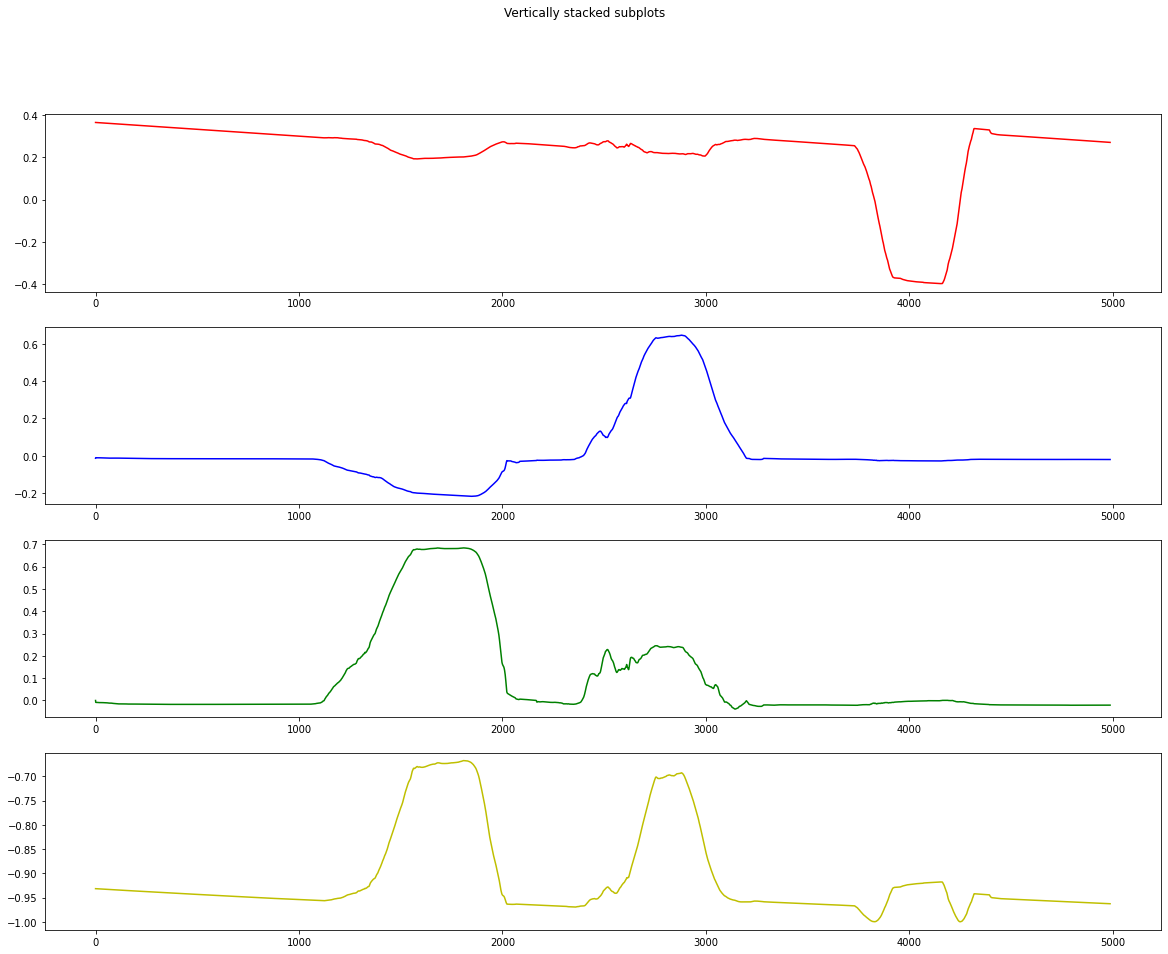

In [175]:
# Plot data EKS QS
fig, axs = plt.subplots(4, figsize = (20,15))
fig.suptitle('Vertically stacked subplots')
axs[0].plot(q1[:,0], 'r')
axs[1].plot(q1[:,1], 'b')
axs[2].plot(q1[:,2], 'g')
axs[3].plot(q1[:,3], 'y')

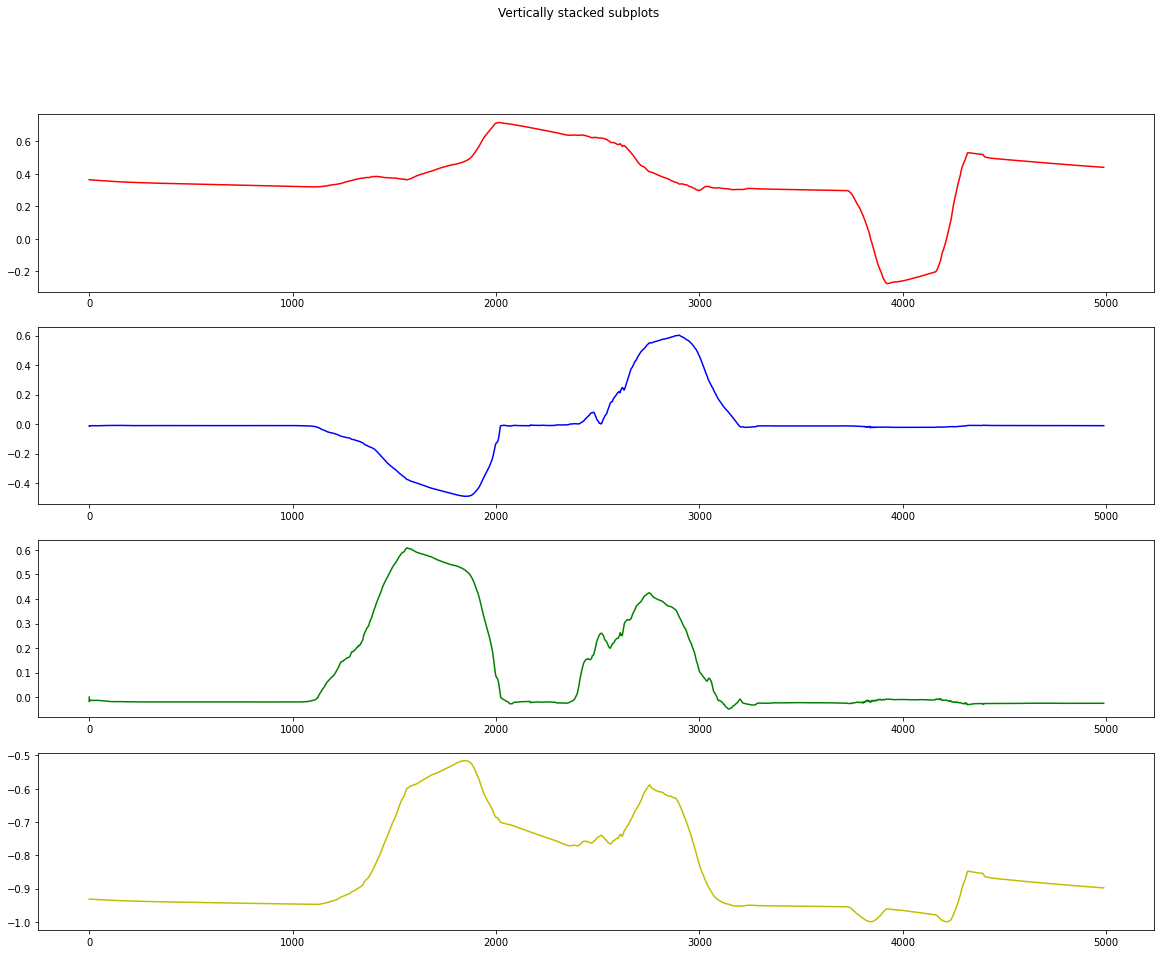

In [176]:
# Plot data EKS DS
fig, axs = plt.subplots(4, figsize = (20,15))
fig.suptitle('Vertically stacked subplots')
axs[0].plot(q2[:,0], 'r')
axs[1].plot(q2[:,1], 'b')
axs[2].plot(q2[:,2], 'g')
axs[3].plot(q2[:,3], 'y')

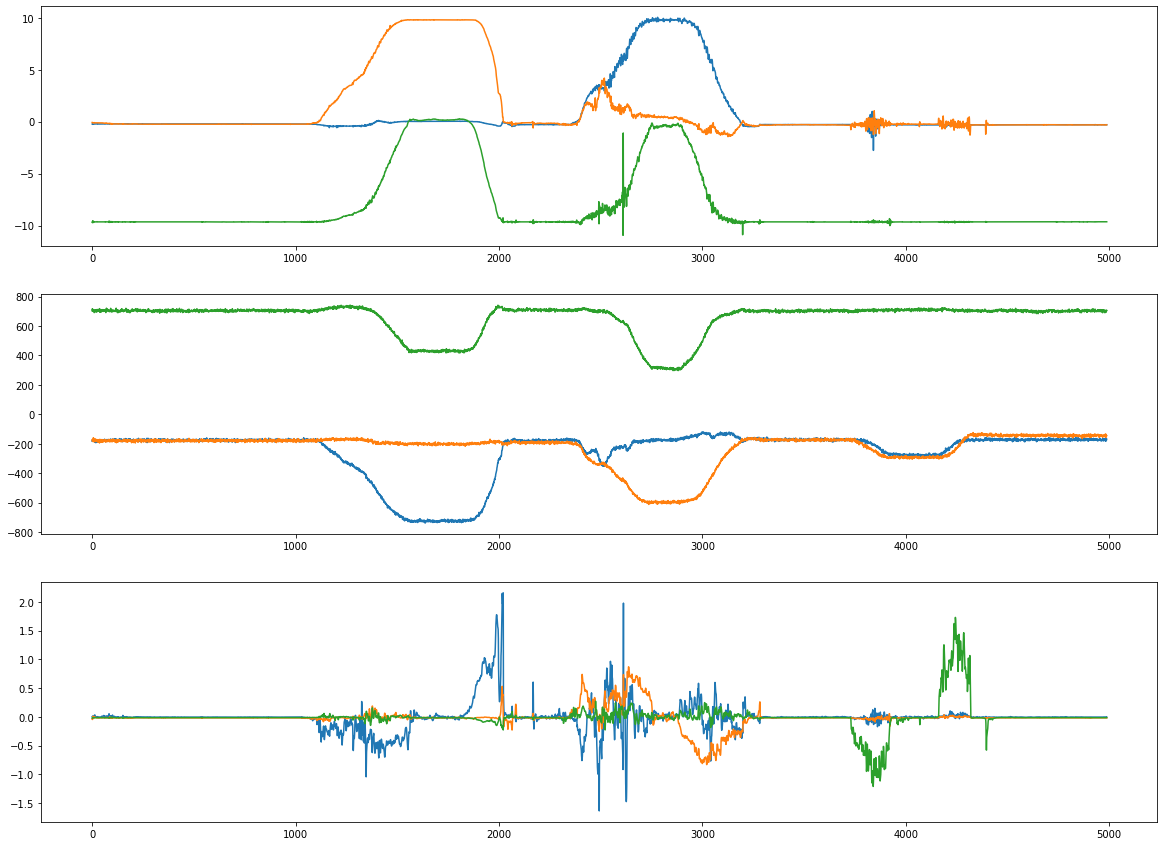

In [177]:
fig, axs = plt.subplots(3, figsize = (20,15))
axs[0].plot(acc[:,0])
axs[0].plot(acc[:,1])
axs[0].plot(acc[:,2])
axs[1].plot(mag[:,0])
axs[1].plot(mag[:,1])
axs[1].plot(mag[:,2])
axs[2].plot(gyr[:,0])
axs[2].plot(gyr[:,1])
axs[2].plot(gyr[:,2])

In [178]:
qz = q2
phi = np.zeros(len(qz))
theta = np.zeros(len(qz))
psi = np.zeros(len(qz))
i = 0

for q in qz:
    [phi[i], theta[i] , psi[i]] = quat_to_ypr(q)
    i += 1

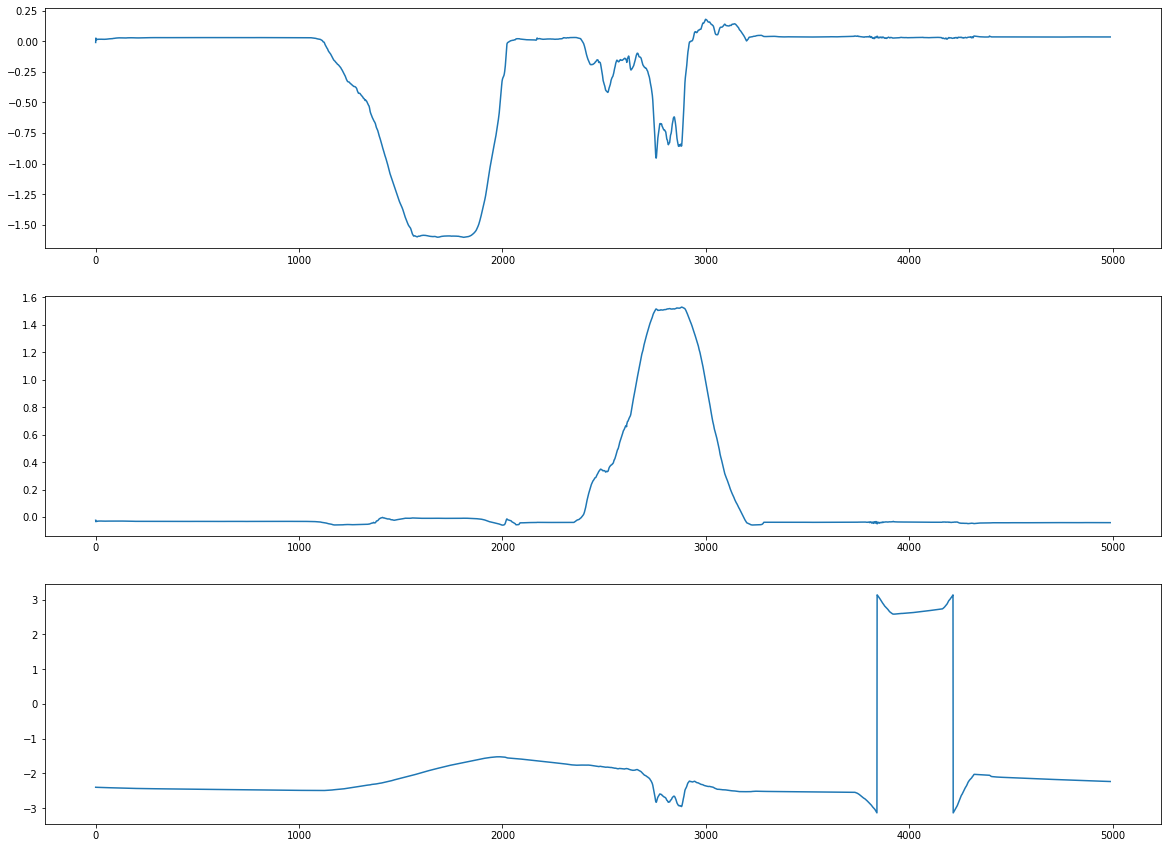

In [179]:
fig, axs = plt.subplots(3, figsize = (20,15))
axs[0].plot(phi)
axs[1].plot(theta)
axs[2].plot(psi)

In [180]:
play_vid(q2)

fps: 237


# Visualization

In [30]:
import pygame
import math
from OpenGL.GL import *
from OpenGL.GLU import *
from pygame.locals import *


pygame 2.1.0 (SDL 2.0.16, Python 3.9.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [31]:
import time
def play_vid(q):
    video_flags = OPENGL | DOUBLEBUF
    pygame.init()
    screen = pygame.display.set_mode((640, 480), video_flags)
    resizewin(640, 480)
    init()
    frames = 0
    ticks = pygame.time.get_ticks()
    for i in range(0,len(q)):
        event = pygame.event.poll() 
        if event.type == QUIT or (event.type == KEYDOWN and event.key == K_ESCAPE):
            break           
        [w, nx, ny, nz] = q[i]
        draw(w, nx, ny, nz)

        pygame.display.flip()
        frames += 1
        #time.sleep(1/100)
        
    print("fps: %d" % ((frames*1000)/(pygame.time.get_ticks()-ticks)))
    pygame.display.quit()

In [32]:
def resizewin(width, height):
    """
    For resizing window
    """
    if height == 0:
        height = 1
    glViewport(0, 0, width, height)
    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()
    gluPerspective(45, 1.0*width/height, 0.1, 100.0)
    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()

In [33]:
def init():
    glShadeModel(GL_SMOOTH)
    glClearColor(0.0, 0.0, 0.0, 0.0)
    glClearDepth(1.0)
    glEnable(GL_DEPTH_TEST)
    glDepthFunc(GL_LEQUAL)
    glHint(GL_PERSPECTIVE_CORRECTION_HINT, GL_NICEST)

In [34]:
def draw(w, nx, ny, nz):
    glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
    glLoadIdentity()
    glTranslatef(0, 0.0, -7.0)

    drawText((-2.6, 1.8, 2), "Press Escape to exit", 18)


    [yaw, pitch , roll] = quat_to_ypr([w, nx, ny, nz])
    drawText((-2.6, -1.8, 2), "Yaw: %f, Pitch: %f, Roll: %f" %(yaw, pitch, roll), 16)
    glRotatef(2 * math.acos(w) * 180.00/math.pi, -1 * nx, nz, ny)


    glBegin(GL_QUADS)
    glColor3f(0.0, 1.0, 0.0)
    glVertex3f(1.0, 0.2, -1.0)
    glVertex3f(-1.0, 0.2, -1.0)
    glVertex3f(-1.0, 0.2, 1.0)
    glVertex3f(1.0, 0.2, 1.0)

    glColor3f(1.0, 0.5, 0.0)
    glVertex3f(1.0, -0.2, 1.0)
    glVertex3f(-1.0, -0.2, 1.0)
    glVertex3f(-1.0, -0.2, -1.0)
    glVertex3f(1.0, -0.2, -1.0)

    glColor3f(1.0, 0.0, 0.0)
    glVertex3f(1.0, 0.2, 1.0)
    glVertex3f(-1.0, 0.2, 1.0)
    glVertex3f(-1.0, -0.2, 1.0)
    glVertex3f(1.0, -0.2, 1.0)

    glColor3f(1.0, 1.0, 0.0)
    glVertex3f(1.0, -0.2, -1.0)
    glVertex3f(-1.0, -0.2, -1.0)
    glVertex3f(-1.0, 0.2, -1.0)
    glVertex3f(1.0, 0.2, -1.0)

    glColor3f(0.0, 0.0, 1.0)
    glVertex3f(-1.0, 0.2, 1.0)
    glVertex3f(-1.0, 0.2, -1.0)
    glVertex3f(-1.0, -0.2, -1.0)
    glVertex3f(-1.0, -0.2, 1.0)

    glColor3f(1.0, 0.0, 1.0)
    glVertex3f(1.0, 0.2, -1.0)
    glVertex3f(1.0, 0.2, 1.0)
    glVertex3f(1.0, -0.2, 1.0)
    glVertex3f(1.0, -0.2, -1.0)
    glEnd()


def drawText(position, textString, size):
    font = pygame.font.SysFont("Courier", size, True)
    textSurface = font.render(textString, True, (255, 255, 255, 255), (0, 0, 0, 255))
    textData = pygame.image.tostring(textSurface, "RGBA", True)
    glRasterPos3d(*position)
    glDrawPixels(textSurface.get_width(), textSurface.get_height(), GL_RGBA, GL_UNSIGNED_BYTE, textData)


In [35]:
play_vid(q1)

fps: 224


In [60]:
with np.printoptions(threshold=np.inf):
    print(acc)

[[-2.2551500e-01 -7.8440000e-02 -9.6677300e+00]
 [-2.3532000e-01 -8.8245000e-02 -9.6579250e+00]
 [-2.5493000e-01 -9.8050000e-02 -9.7167550e+00]
 [-2.3532000e-01 -8.8245000e-02 -9.5402650e+00]
 [-2.4512500e-01 -1.0785500e-01 -9.7167550e+00]
 [-2.4512500e-01 -9.8050000e-02 -9.6579250e+00]
 [-2.4512500e-01 -9.8050000e-02 -9.6187050e+00]
 [-2.3532000e-01 -1.0785500e-01 -9.6187050e+00]
 [-2.4512500e-01 -1.1766000e-01 -9.6873400e+00]
 [-2.2551500e-01 -9.8050000e-02 -9.6677300e+00]
 [-2.2551500e-01 -8.8245000e-02 -9.6383150e+00]
 [-2.3532000e-01 -1.0785500e-01 -9.6481200e+00]
 [-2.2551500e-01 -1.0785500e-01 -9.6481200e+00]
 [-2.1571000e-01 -1.1766000e-01 -9.6481200e+00]
 [-2.2551500e-01 -1.0785500e-01 -9.6579250e+00]
 [-2.2551500e-01 -1.1766000e-01 -9.6383150e+00]
 [-2.2551500e-01 -1.0785500e-01 -9.6383150e+00]
 [-2.1571000e-01 -1.1766000e-01 -9.6383150e+00]
 [-2.2551500e-01 -1.1766000e-01 -9.6481200e+00]
 [-2.2551500e-01 -1.0785500e-01 -9.6383150e+00]
 [-2.2551500e-01 -1.1766000e-01 -9.64812

In [ ]:
pygame.display.quit()

In [ ]:
np.max(gyr)

In [ ]:
acc = df.acc_x.values, df.acc_y.values ,df.acc_z.values
acc = np.transpose(acc)*9.805/1000
#acc = acc[5:]
with np.printoptions(threshold=np.inf):
    print(acc)

In [ ]:
mag = df.mag_x.values, df.mag_y.values ,df.mag_z.values
mag = np.transpose(mag)
with np.printoptions(threshold=np.inf):
    print(mag)

In [ ]:
gyr = df.gyr_x.values, df.gyr_y.values ,df.gyr_z.values
gyr = np.transpose(gyr)/1000
with np.printoptions(threshold=np.inf):
    print(gyr)

In [ ]:
aa = np.array([-183, -166,  709])
aa/LA.norm(aa)

In [ ]:
aaa = np.array([-0.24373453, -0.22109252,  0.94430481])
aaa/LA.norm(aaa)